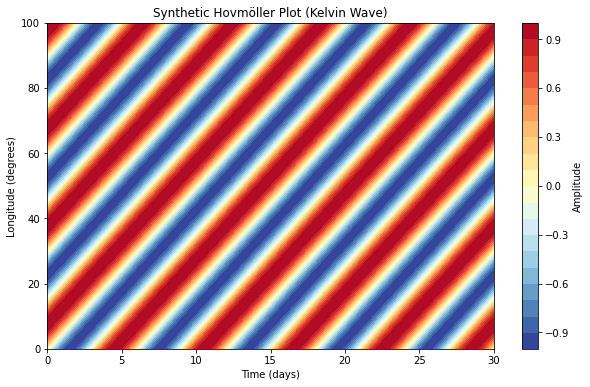

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Set up parameters for the synthetic data
# Time and space axis
time = np.linspace(0, 30, 300)  # 30 days, 300 time steps
space = np.linspace(0, 100, 200)  # 100 degrees longitude, 200 space steps

# Create a 2D grid for space and time
T, X = np.meshgrid(time, space)

# Set parameters for the wave (Kelvin wave)
wave_number = 2 * np.pi / 30  # wave number (cycles per 30 degrees longitude)
phase_speed = 5  # phase speed in degrees per day

# Generate the Kelvin wave pattern as a function of space and time
wave = np.sin(wave_number * (X - phase_speed * T))

# Plot the synthetic Hovmöller plot
plt.figure(figsize=(10, 6))
plt.contourf(time, space, wave, levels=20, cmap='RdYlBu_r')
plt.colorbar(label='Amplitude')
plt.title('Synthetic Hovmöller Plot (Kelvin Wave)')
plt.xlabel('Time (days)')
plt.ylabel('Longitude (degrees)')
plt.show()


Estimated Phase Speed: 0.04 degrees per day


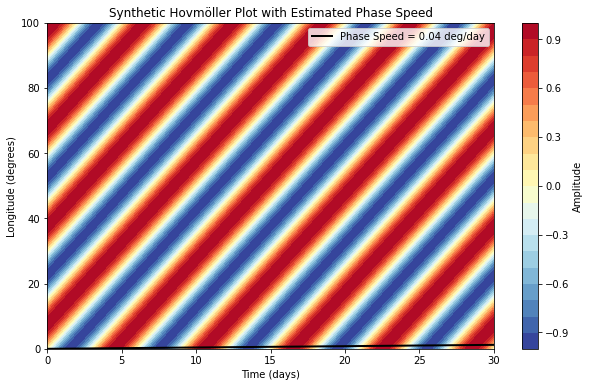

In [3]:
# Function to estimate phase speed
def estimate_phase_speed(T, X, wave_data, threshold=0.5):
    # Find the position of the wave peaks (where wave amplitude exceeds a threshold)
    peak_positions = []
    
    for i in range(wave_data.shape[1]):  # Loop over each time step
        # Find the indices where wave amplitude is near the threshold value
        indices = np.where(wave_data[:, i] > threshold)[0]
        
        if len(indices) > 0:
            # Get the mean position of these indices
            mean_position = np.mean(X[indices, i])
            peak_positions.append(mean_position)
        else:
            peak_positions.append(np.nan)
    
    peak_positions = np.array(peak_positions)
    time_points = T[0, :]
    
    # Compute phase speed as the slope of the line (distance/time)
    valid_positions = ~np.isnan(peak_positions)  # Exclude NaN values
    slope = np.polyfit(time_points[valid_positions], peak_positions[valid_positions], 1)[0]
    
    return slope

# Estimate phase speed from the synthetic data
# Estimate phase speed from the synthetic data
estimated_phase_speed = estimate_phase_speed(T, X, wave)

# Print the estimated phase speed
print(f"Estimated Phase Speed: {estimated_phase_speed:.2f} degrees per day")

# Plot the wave peaks to visualize the phase speed line
plt.figure(figsize=(10, 6))
plt.contourf(time, space, wave, levels=20, cmap='RdYlBu_r')

# Now use the estimated phase speed result, not the function name itself
plt.plot(time, estimated_phase_speed * time, color='black', lw=2, label=f'Phase Speed = {estimated_phase_speed:.2f} deg/day')

plt.colorbar(label='Amplitude')
plt.title('Synthetic Hovmöller Plot with Estimated Phase Speed')
plt.xlabel('Time (days)')
plt.ylabel('Longitude (degrees)')
plt.legend()
plt.show()


In [ ]:
# Data source from the model: /DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK

# Kind of data : filtered_sla_lat_-25.35_lon_157.95.nc

# Type of content: 

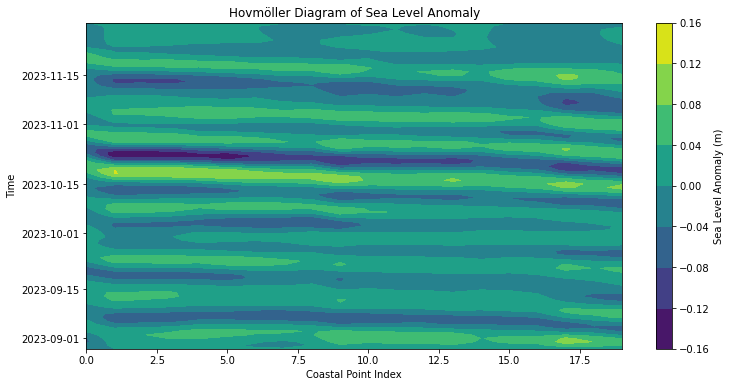

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from scipy.spatial import cKDTree
import cartopy.feature as cfeature
import os
import re

# Step 1: Define the parallelogram
parallelogram_vertices = np.array([
    [149, -38],  # Bottom-left
    [158, -38],  # Bottom-right
    [158, -25],  # Top-right
    [149, -25]   # Top-left
])
parallelogram = Polygon(parallelogram_vertices)

# Step 2: Extract coastline using Cartopy
coastline = list(cfeature.COASTLINE.geometries())
coastline_points = []

for geometry in coastline:
    if geometry.intersects(parallelogram):
        if geometry.geom_type == 'LineString':
            coastline_points.extend(np.array(geometry.coords))
        elif geometry.geom_type == 'MultiLineString':
            for line in geometry:
                coastline_points.extend(np.array(line.coords))

coastline_points = np.array(coastline_points)

# Filter coastline points within the parallelogram
filtered_points = np.array([point for point in coastline_points if parallelogram.contains(Point(point))])

# Step 3: Interpolate Equally Spaced Points
coastline_line = LineString(filtered_points)
n_points = 20  # Define the number of equally spaced points
distances = np.linspace(0, coastline_line.length, n_points)
interpolated_points = np.array([coastline_line.interpolate(d).coords[0] for d in distances])

# Step 4: Find Closest Grid Points
# Extract grid point coordinates from filenames
grid_data_dir = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK"
grid_points = []
files = os.listdir(grid_data_dir)

for file in files:
    match = re.search(r"lat_(-?\d+\.\d+)_lon_(-?\d+\.\d+)", file)
    if match:
        lat, lon = map(float, match.groups())
        grid_points.append((lon, lat))

grid_points = np.array(grid_points)

# Use cKDTree for efficient nearest-neighbor search
tree = cKDTree(grid_points)
distances, indices = tree.query(interpolated_points)
closest_points = grid_points[indices]

# Step 5: Extract Time Series
time_series_list = []

for i, index in enumerate(indices):
    file_name = f"filtered_sla_lat_{grid_points[index][1]}_lon_{grid_points[index][0]}.nc"
    file_path = os.path.join(grid_data_dir, file_name)

    # Open the NetCDF file and extract time series
    ds = xr.open_dataset(file_path)
    time_series = ds['filtered_sla'].values  # Assuming 'sla' is the variable name
    time_series_list.append(time_series)

time_series_matrix = np.array(time_series_list)

# Step 6: Create Hovmöller Diagram
time = ds['time'].values  # Assuming 'time' is the time coordinate
plt.figure(figsize=(12, 6))
plt.contourf(range(len(interpolated_points)), time, time_series_matrix.T, cmap='viridis')
plt.colorbar(label='Sea Level Anomaly (m)')
plt.xlabel('Coastal Point Index')
plt.ylabel('Time')
plt.title('Hovmöller Diagram of Sea Level Anomaly')
plt.show()


In [3]:
ds

<xarray.Dataset>
Dimensions:         (time: 94)
Coordinates:
  * time            (time) datetime64[ns] 2023-08-29 2023-08-30 ... 2023-11-30
    latitude        float64 ...
    longitude       float64 ...
Data variables:
    unfiltered_sla  (time) float64 ...
    filtered_sla    (time) float64 ...